In [1]:
import sys
import json
import pandas as pd
import numpy as np
import itertools
import glob, os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted
from biom.table import Table

sys.path.append('../')

from src.etl import *
from src.eda import *
from src.graph import *
from src.sparsify import *

In [2]:
# sam-t2d config
disease = 'sam-t2d'
otu_table_fp = '../data/sam-t2d/otu_table.csv'
metadata_fp = '../data/sam-t2d/metadata.csv'
rare_otu_threshold = 1
transformation = 'norm'
disease_col = 't2d'
group0 = 'No'
group1 = 'Yes'

In [4]:
# pcos config
disease = 'pcos'
otu_table_fp = '../data/pcos/otu_table.csv'
metadata_fp = '../data/pcos/metadata.csv'
rare_otu_threshold = 1
transformation = 'norm'
disease_col = 'group'
group0 = 'HC'
group1 = 'PCOS'

In [3]:
otu_table = pd.read_csv(otu_table_fp, index_col=0)
filtered_otu_table = filter_rare_otus(otu_table, rare_otu_threshold)
metadata = pd.read_csv(metadata_fp, index_col=0)

if disease == 'sam-t2d':
    merged = metadata.merge(filtered_otu_table, how='inner', left_index=True, right_index=True)
else: 
    merged = pd.concat([metadata, filtered_otu_table], axis=1)
healthy = merged[merged[disease_col] == 0] #.drop(columns=[disease_col])
diseased = merged[merged[disease_col] == 1] #.drop(columns=[disease_col])

In [4]:
healthy_otu = healthy.drop(columns=list(metadata.columns))
data_sparse_healthy, data_sparse_diseased, keep_nodes_healthy, keep_nodes_diseased = get_sig_cor_pairs_glasso(
                    f'../data/{disease}/glasso_{group0}_{transformation}.csv', 
                    f'../data/{disease}/glasso_{group1}_{transformation}.csv', 
                    list(healthy_otu.columns)
                )

In [5]:
healthy = healthy[keep_nodes_healthy]
diseased = diseased[keep_nodes_diseased]
sparse_method_fp = 'glasso'

In [6]:
healthy_pcos_graph = run_pc_depth2(healthy, data_sparse_healthy, 0.01, f'{disease}/{sparse_method_fp}_{group0}_{transformation}')

  0%|          | 0/41 [00:00<?, ?it/s]

In [7]:
pcos_pcos_graph = run_pc_depth2(diseased, data_sparse_diseased, 0.01, f'{disease}/{sparse_method_fp}_{group1}_{transformation}')

  0%|          | 0/42 [00:00<?, ?it/s]

In [10]:
healthy_pcos_graph.graph

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
healthy_temp = []

for i in range(healthy.shape[1]):
    for j in range(healthy.shape[1]):
        if healthy_pcos_graph.graph[i, j] != 0:
            healthy_temp.append(healthy.columns[i])
            healthy_temp.append(healthy.columns[j])

In [9]:
np.unique(healthy_temp)

array(['d__Bacteria;__;__;__;__;__',
       'd__Bacteria;p__Actinomycetota;c__Actinomycetes;o__Actinomycetales;f__Bifidobacteriaceae;g__Bifidobacterium_388775',
       'd__Bacteria;p__Actinomycetota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Christensenellales;f__Aristaeellaceae;g__SFMI01',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;__',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A_141781',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospira',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Oscillospirales;f__Acutalibacteraceae;__',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Oscillospirales;f__Acutalibacteraceae;g__Acutalibacter',
       'd__Bacteria;p__Bacillota_

In [10]:
pcos_temp = []

for i in range(diseased.shape[1]):
    for j in range(diseased.shape[1]):
        if pcos_pcos_graph.graph[i, j] != 0:
            pcos_temp.append(diseased.columns[i])
            pcos_temp.append(diseased.columns[j])

In [11]:
np.unique(pcos_temp)

array(['d__Bacteria;p__Actinomycetota;c__Actinomycetes;o__Actinomycetales;f__Bifidobacteriaceae;g__Bifidobacterium_388775',
       'd__Bacteria;p__Actinomycetota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Christensenellales;f__CAG-138;g__PeH17',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;__',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;__',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Anaerobutyricum',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A_141781',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospira',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Oscillospirale

In [15]:
# HC and PCOS share 45 microbes
shared = np.intersect1d(np.unique(healthy_temp), np.unique(pcos_temp))
shared.shape

(27,)

In [17]:
# HC have an additional 15
np.unique(healthy_temp)[~np.in1d(np.unique(healthy_temp), shared)]

array(['d__Bacteria;__;__;__;__;__',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Christensenellales;f__Aristaeellaceae;g__SFMI01',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Oscillospirales;f__Acutalibacteraceae;g__Acutalibacter',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__UBA1381;f__UBA1381;g__Hominilimicola',
       'd__Bacteria;p__Bacillota_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A_39470',
       'd__Bacteria;p__Bacillota_C;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae_42771;g__Mitsuokella',
       'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Alloprevotella',
       'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae_A_595427;g__Sutterella',
       'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales_737866;f__Enterobacteriaceae_A_726016;__',
       'd__Bacteria;

In [19]:
# PCOS have an additional 17
np.unique(pcos_temp)[~np.in1d(np.unique(pcos_temp), shared)]

array(['d__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Christensenellales;f__CAG-138;g__PeH17',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;__',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Anaerobutyricum',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Oscillospirales;f__Acutalibacteraceae;g__CAG-177',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Oscillospirales;f__Oscillospiraceae_88309;g__Faecousia',
       'd__Bacteria;p__Bacillota_A_368345;c__Clostridia_258483;o__Oscillospirales;f__Oscillospiraceae_88309;g__Hominicoprocola',
       'd__Bacteria;p__Bacillota_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__URXU01',
       'd__Bacteria;p__Bacillota_C;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae_42771;g__Megamonas',
       'd__Bacteria;p__Bacillota_C;c__Negativicutes;o__Veillonellales;f__V

In [ ]:
diagram.get_label_by_id("10").set_text("\n".join(A - B))
diagram.get_label_by_id("11").set_text("\n".join(A & B))
diagram.get_label_by_id("01").set_text("\n".join(B - A))
# Modify font sizes
for text in diagram.set_labels:
 text.set_fontsize(24)
for text in diagram.subset_labels:
 text.set_fontsize(14)

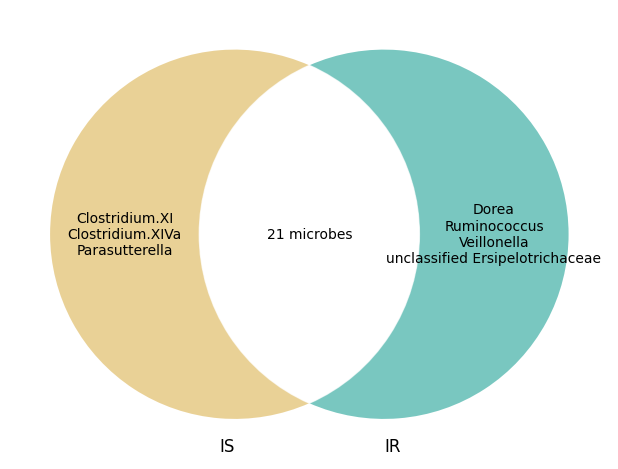

In [56]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted

t2d_is_microbes = ['Clostridium.XI', 'Clostridium.XIVa', 'Parasutterella']
t2d_ir_microbes = ['Dorea', 'Ruminococcus', 'Veillonella', 'unclassified Ersipelotrichaceae']
t2d_is = set(['Clostridium.XI', 'Clostridium.XIVa', 'Parasutterella', '21'])
t2d_ir = set(['Dorea', 'Ruminococcus', 'Veillonella', 'unclassified Ersipelotrichaceae', '21'])

t2d_venn = venn2_unweighted([t2d_is, t2d_ir], ('IS', 'IR'), set_colors=("#E1BE6A", "#40B0A6"),alpha=0.7)

t2d_venn.get_patch_by_id('11').set_color("white") 

t2d_venn.get_label_by_id('10').set_text('\n'.join(t2d_is_microbes))
t2d_venn.get_label_by_id('11').set_text('21 microbes')
t2d_venn.get_label_by_id('01').set_text('\n'.join(t2d_ir_microbes))

plt.tight_layout()
plt.savefig('t2d_microbe_microbe_venn.png', dpi=300)

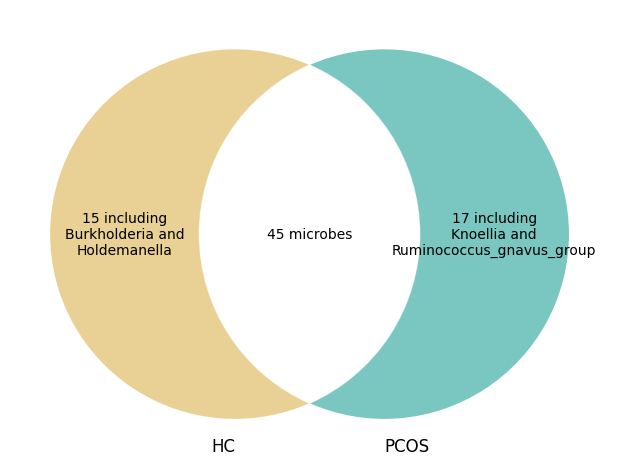

In [57]:
pcos_hc_microbes = list(np.unique(healthy_temp)[~np.in1d(np.unique(healthy_temp), shared)])
pcos_pcos_microbes = list(np.unique(pcos_temp)[~np.in1d(np.unique(pcos_temp), shared)])
pcos_hc = set(pcos_hc_microbes + ['45'])
pcos_pcos = set(pcos_pcos_microbes + ['45'])

pcos_venn = venn2_unweighted([pcos_hc, pcos_pcos], ('HC', 'PCOS'), set_colors=('#E1BE6A', '#40B0A6'), alpha=0.7)

pcos_venn.get_patch_by_id('11').set_color("white") 

pcos_venn.get_label_by_id('10').set_text('\n'.join(['15 including', 'Burkholderia and', 'Holdemanella']))
pcos_venn.get_label_by_id('11').set_text('45 microbes')
pcos_venn.get_label_by_id('01').set_text('\n'.join(['17 including', 'Knoellia and', 'Ruminococcus_gnavus_group']))

plt.tight_layout()
plt.savefig('pcos_microbe_microbe_venn.png', dpi=300)